##**Here we do the predictive analytics on two useful tasks:**

**This predicts**

**1. Multi-class classification:**

-> Predict Land_Cover_Type from features (Region, Year, Area_sq_km, NDVI, Population_Density, Temperature_Anomaly).

-> Useful for mapping/label propagation, identifying mislabelled points, or building a classifier to label new image-derived parcels.

**2. Regression:**

-> Predict Area_sq_km (area) from the other features (including Land_Cover_Type, encoded).

-> Useful for estimating area given satellite-derived indices or for gap-filling missing area values.

**Both the above tasks include:**

1. Data loading & basic cleaning,

2. Feature engineering and encoding,

3. Train / test split,

4. Baseline models (Random Forest + XGBoost),

5. Cross-validated hyperparameter search (lightweight, quick defaults),

6. Model evaluation (classification report, confusion matrix, MAE/RMSE),

7. Feature importance (SHAP summary),

8. Saving predictions and model artifacts for downstream use,

9. Producing CSV outputs (predictions_classification.csv, predictions_regression.csv, feature_importances.csv) that we can import into Power BI or other dashboards.

##**Why and When to use SHAP ?**

**1. Debugging and Optimization:**

**(a) Identify incorrect predictions:** Use SHAP to understand which features caused a model to make a wrong prediction.

**(b) Detect performance issues:** Find out why a model performs well on one dataset but poorly on a different one.

**2. Increasing Trust and Transparency:**

**(a) Explain decisions to stakeholders:** Provide clear, understandable reasons for a model's output to build confidence in its predictions.

**(b) Verify model logic:** Ensure the model is using features in a logical and expected way.

**3. Data and Model Understanding:**

**(a) Uncover hidden patterns:** Reveal non-linear relationships and complex interactions between features that the model has learned.

**(b)Explore feature contributions:** Understand the direction and magnitude of a feature's impact on the prediction.

**Step 1: Install required packages**

In [1]:
# Cell 1: install packages (run once)
!pip install -q scikit-learn xgboost shap pandas matplotlib seaborn
# If Colab already has them, pip will skip or upgrade quietly.


**Step 2: Load data and perform EDA**

In [2]:
import pandas as pd
# If running in Colab, upload your dataset
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Specify the path to the CSV file in your Drive
path = '/content/drive/My Drive/Global 2_Land_Use_Change_10000.csv'

# Read the CSV file and gather the data
df = pd.read_csv(path, index_col=0, encoding='windows-1252')
# Reset the index to make 'Region' a column
df = df.reset_index()
print(df)
print("Shape:", df.shape)
print("\nColumns and dtypes:\n", df.dtypes)
print("\nUnique counts:")
print(df.nunique())
display(df.head())

Mounted at /content/drive
             Region  Year Land_Cover_Type   Area_sq_km      NDVI  \
0            Arctic  2001          Forest  3254.964695  0.484491   
1            Africa  2006           Water  5921.290081  0.794882   
2              Asia  2008     Agriculture  3879.211069  0.700630   
3            Arctic  2009     Barren Land  1421.067183  0.328878   
4            Europe  2017     Agriculture  7867.979345  0.222623   
...             ...   ...             ...          ...       ...   
9995         Europe  2018     Agriculture  3097.800401  0.588009   
9996           Asia  2004        Wetlands  4472.522214  0.408794   
9997  South America  2024           Urban   573.958602  0.236344   
9998         Europe  2010          Forest  8423.435824  0.947741   
9999  South America  2009           Water   929.500156  0.820377   

      Population_Density  Temperature_Anomaly  
0               0.960719             2.386881  
1              47.002582            -0.026336  
2            

,Region,Year,Land_Cover_Type,Area_sq_km,NDVI,Population_Density,Temperature_Anomaly
0,Arctic,2001,Forest,3254.964695,0.484491,0.960719,2.386881
1,Africa,2006,Water,5921.290081,0.794882,47.002582,-0.026336
2,Asia,2008,Agriculture,3879.211069,0.700630,1.357280,0.688704
3,Arctic,2009,Barren Land,1421.067183,0.328878,20.344339,2.935222
4,Europe,2017,Agriculture,7867.979345,0.222623,172.018320,1.264583


**Step 3: Preprocessing & Feature engineering functions**

In [3]:
# Cell 3: preprocessing helpers
import numpy as np
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

def preprocess_for_classification(df, drop_na=True):
    # Input: raw dataframe
    df = df.copy()
    if drop_na:
        df = df.dropna().reset_index(drop=True)

    # Feature columns
    features = ['Region','Year','Area_sq_km','NDVI','Population_Density','Temperature_Anomaly']
    target = 'Land_Cover_Type'
    X = df[features].copy()
    y = df[target].copy()

    # Basic encoding: one-hot Region; Year as numeric (already numeric)
    X = pd.get_dummies(X, columns=['Region'], drop_first=True)
    return X, y

def preprocess_for_regression(df, drop_na=True):
    df = df.copy()
    if drop_na:
        df = df.dropna().reset_index(drop=True)

    features = ['Region','Year','NDVI','Population_Density','Temperature_Anomaly','Land_Cover_Type']
    target = 'Area_sq_km'
    X = df[features].copy()
    y = df[target].copy()

    # Region + Land_Cover_Type one-hot
    X = pd.get_dummies(X, columns=['Region','Land_Cover_Type'], drop_first=True)
    return X, y


**Step 4: Classification Selected ML Algorithms: train RandomForest + XGBoost, and evaluate to select the best fit AI model**

Random Forest — Accuracy: 0.28
              precision    recall  f1-score   support

 Agriculture       0.19      0.19      0.19       340
 Barren Land       0.20      0.15      0.17       326
      Forest       0.38      0.28      0.32       341
       Urban       0.40      0.78      0.53       325
       Water       0.17      0.14      0.15       332
    Wetlands       0.19      0.15      0.17       336

    accuracy                           0.28      2000
   macro avg       0.26      0.28      0.26      2000
weighted avg       0.26      0.28      0.26      2000



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:26:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost — Accuracy: 0.2715
              precision    recall  f1-score   support

 Agriculture       0.23      0.23      0.23       340
 Barren Land       0.19      0.15      0.17       326
      Forest       0.34      0.29      0.32       341
       Urban       0.42      0.60      0.49       325
       Water       0.19      0.18      0.18       332
    Wetlands       0.19      0.18      0.19       336

    accuracy                           0.27      2000
   macro avg       0.26      0.27      0.26      2000
weighted avg       0.26      0.27      0.26      2000



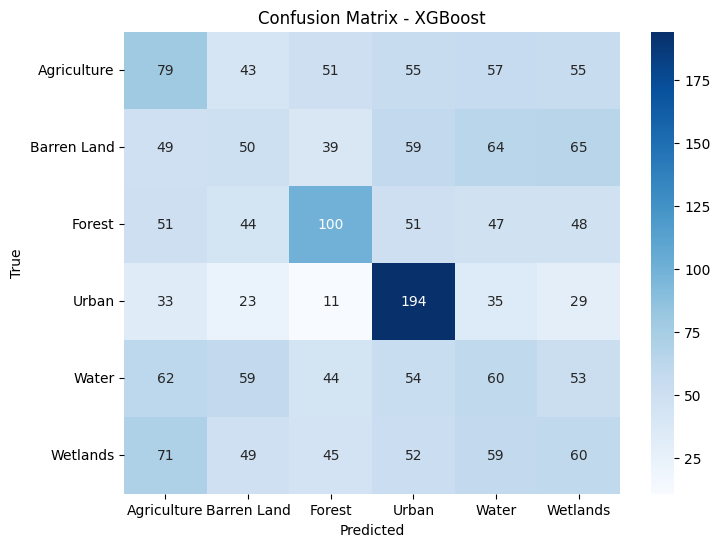

Saved predictions to /content/predictions_classification.csv


In [5]:
# Cell 4: classification pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

# Prepare data
Xc, yc = preprocess_for_classification(df)
# Encode target labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
yc_enc = le.fit_transform(yc)

# Train/test split
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc_enc, test_size=0.2, random_state=RANDOM_STATE, stratify=yc_enc)

# 1) Random Forest baseline
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(Xc_train, yc_train)
rf_preds = rf.predict(Xc_test)

print("Random Forest — Accuracy:", accuracy_score(yc_test, rf_preds))
print(classification_report(yc_test, rf_preds, target_names=le.classes_))

# 2) XGBoost (quick)
xgb = XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE, n_jobs=4)
xgb.fit(Xc_train, yc_train)
xgb_preds = xgb.predict(Xc_test)

print("XGBoost — Accuracy:", accuracy_score(yc_test, xgb_preds))
print(classification_report(yc_test, xgb_preds, target_names=le.classes_))

# Confusion matrix (XGBoost)
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(yc_test, xgb_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - XGBoost")
plt.show()

# Save predictions to CSV for downstream use
pred_df = Xc_test.copy()
pred_df['true_label'] = le.inverse_transform(yc_test)
pred_df['pred_label'] = le.inverse_transform(xgb_preds)
pred_df.to_csv("/content/predictions_classification.csv", index=False)
print("Saved predictions to /content/predictions_classification.csv")


**Conclusion for the above cell output: what Actionable next steps should be taken after inspecting the contents of  predictions_classification.csv**

1. If overall accuracy is good but some classes are poor → get more labeled examples for those classes or perform class-balanced sampling / class weights.

2. If errors concentrate in certain regions or years → add region/time features or train region-specific models.

3. If model is uncertain on many rows → add more informative features (e.g., derived spectral indices) or use ensemble / calibration.

4. If high-confidence wrong predictions → inspect labels for noise — relabel suspect records.

5. If you need probabilistic decisions → save and use predict_proba and set business thresholds (e.g., only auto-accept predictions with max_prob > 0.8).

6. Use SHAP on misclassified rows to see which features pushed the prediction to the wrong class.

**Step 5: Feature importance + SHAP for classification using XGBoost which is selected after evaluation**

In [6]:
# Robust SHAP feature importance cell (handles different shap_values shapes)
import shap
import numpy as np
import pandas as pd
import joblib

# ------------- ensure we have a model reference -------------
# Try common names used earlier (xgb classifier or clf). Adjust if your classifier variable has a different name.
model = globals().get("xgb", None) or globals().get("clf", None)
if model is None:
    # try loading from disk if you saved it earlier
    try:
        model = joblib.load("/content/xgb_classification_model.joblib")
        print("Loaded model from /content/xgb_classification_model.joblib")
    except Exception:
        try:
            model = joblib.load("geoluc_clf.joblib")
            print("Loaded model from geoluc_clf.joblib")
        except Exception:
            raise RuntimeError("No classifier model found in variables or disk (xgb / clf). Make sure your XGBoost classifier exists.")

# ------------- prepare X_shap -------------
# Use a sample of the training set (Xc_train must exist and be a DataFrame)
if 'Xc_train' not in globals():
    raise RuntimeError("Xc_train not found in the notebook. Ensure you have Xc_train (training features) in the session.")

if not isinstance(Xc_train, pd.DataFrame):
    Xc_train = pd.DataFrame(Xc_train)

sample_size = min(1000, Xc_train.shape[0])
X_shap = Xc_train.sample(sample_size, random_state=42).reset_index(drop=True)

print("X_shap shape:", X_shap.shape)
print("X_shap columns (first 20):", list(X_shap.columns[:20]))

# ------------- compute SHAP values -------------
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)

print("Raw shap_values type:", type(shap_values))
try:
    sv_arr = np.array(shap_values)
    print("Converted shap_values -> ndarray with shape:", sv_arr.shape)
except Exception as e:
    print("Could not convert shap_values to ndarray directly:", e)
    # still proceed, shap_values might be a list of arrays
    sv_arr = shap_values

# ------------- normalize ndim cases and compute mean-abs -------------
mean_abs = None

# Case A: shap_values is a list of arrays -> shape: list length = n_classes, each array (n_samples, n_features)
if isinstance(shap_values, list):
    print("Detected shap_values as list (multiclass). Each element shape examples:")
    for i, s in enumerate(shap_values[:3]):
        print(f" class {i} shape: {np.array(s).shape}")
    # convert list -> array with shape (n_classes, n_samples, n_features)
    arr = np.array([np.array(s) for s in shap_values])
    if arr.ndim != 3:
        raise ValueError(f"Unexpected converted list->array ndim: {arr.ndim}")
    mean_abs = np.mean(np.abs(arr), axis=(0,1))  # mean across classes & samples -> per-feature

# Case B: shap_values is ndarray
elif isinstance(sv_arr, np.ndarray):
    if sv_arr.ndim == 2:
        # shape (n_samples, n_features) -> single-output model
        print("shap_values ndarray is 2D: (n_samples, n_features)")
        mean_abs = np.mean(np.abs(sv_arr), axis=0)
    elif sv_arr.ndim == 3:
        # Could be (n_classes, n_samples, n_features) OR (n_samples, n_features, n_classes)
        s0, s1, s2 = sv_arr.shape
        nsamples, nfeatures = X_shap.shape
        print("shap_values ndarray is 3D. dims:", (s0, s1, s2), "training sample/features:", (nsamples, nfeatures))

        # If first axis == n_classes and second == n_samples -> (n_classes, n_samples, n_features)
        if s0 != nsamples and s1 == nsamples and s2 == nfeatures:
            # likely (n_classes, n_samples, n_features)
            print("Interpreting as (n_classes, n_samples, n_features).")
            arr = sv_arr
            mean_abs = np.mean(np.abs(arr), axis=(0,1))
        # If first axis == nsamples and second == nfeatures and third == n_classes -> (n_samples, n_features, n_classes)
        elif s0 == nsamples and s1 == nfeatures:
            print("Interpreting as (n_samples, n_features, n_classes). Transposing to (n_classes, n_samples, n_features).")
            arr = np.transpose(sv_arr, (2, 0, 1))  # -> (n_classes, n_samples, n_features)
            mean_abs = np.mean(np.abs(arr), axis=(0,1))
        # If other ordering (rare), try to find the axis matching features
        else:
            # try to locate which axis equals nfeatures
            axes = (s0, s1, s2)
            print("Ambiguous axis ordering; attempting to locate feature axis by matching n_features.")
            feature_axis = None
            for idx, dim in enumerate(axes):
                if dim == nfeatures:
                    feature_axis = idx
                    break
            if feature_axis is None:
                raise ValueError(f"Could not locate feature dimension (n_features={nfeatures}) in shap_values shape {axes}")
            # bring to (n_classes, n_samples, n_features)
            # move feature_axis to last, sample_axis to second, class axis to first
            # identify sample axis if possible
            sample_axis = None
            for idx, dim in enumerate(axes):
                if dim == nsamples:
                    sample_axis = idx
                    break
            class_axis = [0,1,2]
            class_axis.remove(feature_axis)
            if sample_axis in class_axis:
                class_axis.remove(sample_axis)
            else:
                # fallback: assume remaining axis is class
                remaining = [i for i in [0,1,2] if i not in (feature_axis, sample_axis)]
                class_axis = remaining
            # reorder to (class, sample, feature)
            new_order = (class_axis[0], sample_axis if sample_axis is not None else class_axis[0], feature_axis)
            print("Trying transpose to order:", new_order)
            arr = np.transpose(sv_arr, new_order)
            mean_abs = np.mean(np.abs(arr), axis=(0,1))
    else:
        raise ValueError(f"Unhandled shap_values ndarray ndim: {sv_arr.ndim}")
else:
    raise ValueError("shap_values is neither list nor ndarray; cannot proceed.")

# Final sanity check
if mean_abs is None:
    raise ValueError("Failed to compute mean_abs SHAP values (mean_abs is None)")

if len(mean_abs) != X_shap.shape[1]:
    raise ValueError(f"Feature count mismatch: mean_abs length {len(mean_abs)} != X_shap.shape[1] {X_shap.shape[1]}")

# Build DataFrame of feature importances
feat_imp = pd.DataFrame({
    "feature": list(X_shap.columns),
    "mean_abs_shap": mean_abs
}).sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)

display(feat_imp.head(40))
feat_imp.to_csv("/content/feature_importances_classification.csv", index=False)
print("Saved feature_importances_classification.csv to /content/")


X_shap shape: (1000, 11)
X_shap columns (first 20): ['Year', 'Area_sq_km', 'NDVI', 'Population_Density', 'Temperature_Anomaly', 'Region_Arctic', 'Region_Asia', 'Region_Australia', 'Region_Europe', 'Region_North America', 'Region_South America']
Raw shap_values type: <class 'numpy.ndarray'>
Converted shap_values -> ndarray with shape: (1000, 11, 6)
shap_values ndarray is 3D. dims: (1000, 11, 6) training sample/features: (1000, 11)
Interpreting as (n_samples, n_features, n_classes). Transposing to (n_classes, n_samples, n_features).


,feature,mean_abs_shap
0,NDVI,1.124940
1,Temperature_Anomaly,0.285360
2,Population_Density,0.277236
3,Area_sq_km,0.272284
4,Year,0.176164
5,Region_Arctic,0.136905
6,Region_Australia,0.041753
7,Region_South America,0.034614
8,Region_Asia,0.034477
9,Region_Europe,0.034311


Saved feature_importances_classification.csv to /content/


**Step 6: Regression: predict Area_sq_km**

In [7]:
# Cell 6: regression pipeline to predict Area_sq_km
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

Xr, yr = preprocess_for_regression(df)
# Drop infinite / missing if any
mask = yr.notna() & np.isfinite(yr)
Xr = Xr.loc[mask].reset_index(drop=True)
yr = yr.loc[mask].reset_index(drop=True)

Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=RANDOM_STATE)

# Random Forest Regressor baseline
rfr = RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
rfr.fit(Xr_train, yr_train)
rfr_preds = rfr.predict(Xr_test)

print("RandomForestReg — MAE:", mean_absolute_error(yr_test, rfr_preds))
print("RandomForestReg — RMSE:", sqrt(mean_squared_error(yr_test, rfr_preds)))
print("RandomForestReg — R2:", r2_score(yr_test, rfr_preds))

# XGBoost Regressor
xgbr = XGBRegressor(n_estimators=200, random_state=RANDOM_STATE, n_jobs=4)
xgbr.fit(Xr_train, yr_train)
xgbr_preds = xgbr.predict(Xr_test)

print("XGBoostReg — MAE:", mean_absolute_error(yr_test, xgbr_preds))
print("XGBoostReg — RMSE:", sqrt(mean_squared_error(yr_test, xgbr_preds)))
print("XGBoostReg — R2:", r2_score(yr_test, xgbr_preds))

# Save regression predictions
reg_df = Xr_test.copy()
reg_df['true_area_sq_km'] = yr_test
reg_df['pred_area_rf'] = rfr_preds
reg_df['pred_area_xgb'] = xgbr_preds
reg_df.to_csv("/content/predictions_regression.csv", index=False)
print("Saved regression predictions to /content/predictions_regression.csv")


RandomForestReg — MAE: 2435.7745872893847
RandomForestReg — RMSE: 3208.321958818072
RandomForestReg — R2: -0.03817683630063473
XGBoostReg — MAE: 2584.2021848644126
XGBoostReg — RMSE: 3412.7304254200963
XGBoostReg — R2: -0.1746795707899682
Saved regression predictions to /content/predictions_regression.csv


**Step 7(optional) : Save models and brief automated prescriptive output**

In [8]:
# Cell 7: save lightweight model artifacts and produce a prescriptive CSV: top predictors and recommended monitoring regions
import joblib
joblib.dump(xgb, "/content/xgb_classification_model.joblib")
joblib.dump(xgbr, "/content/xgb_regression_model.joblib")
print("Saved models to /content/")

# Simple prescriptive output: identify regions with highest predicted urban growth risk
# We'll create a small example: find regions where predicted mean NDVI is low and Temperature_Anomaly increasing
prescribe = df.groupby('Region').agg({
    'NDVI': 'mean',
    'Temperature_Anomaly': 'mean',
    'Area_sq_km': 'sum'
}).reset_index().sort_values(['NDVI','Temperature_Anomaly'])
prescribe['priority_score'] = (prescribe['Temperature_Anomaly'].rank(ascending=False) + prescribe['NDVI'].rank(ascending=True))
prescribe = prescribe.sort_values('priority_score', ascending=False)
prescribe.to_csv("/content/prescriptive_region_priority.csv", index=False)
print("Saved prescriptive_region_priority.csv to /content/ — open this in Power BI for mapping/prioritization.")
display(prescribe.head(20))


Saved models to /content/
Saved prescriptive_region_priority.csv to /content/ — open this in Power BI for mapping/prioritization.


,Region,NDVI,Temperature_Anomaly,Area_sq_km,priority_score
0,Africa,0.472641,-0.026405,8.641628e+06,14.0
5,North America,0.471496,0.000848,5.752397e+06,11.0
6,South America,0.465792,0.003422,5.775315e+06,9.0
3,Australia,0.460578,-0.016822,5.750550e+06,8.0
4,Europe,0.461505,0.015639,5.686742e+06,6.0
2,Asia,0.464478,0.028709,5.796806e+06,6.0
1,Arctic,0.237130,2.004802,5.639424e+06,2.0


**Summary of results & what to inspect**

In [ ]:
# Cell 8: summarize outputs for user
print("Outputs saved to /content/:")
print(" - predictions_classification.csv")
print(" - feature_importances_classification.csv")
print(" - predictions_regression.csv")
print(" - xgb_classification_model.joblib")
print(" - xgb_regression_model.joblib")
print(" - prescriptive_region_priority.csv")
print("\nWhat to inspect next:")
print(" - Classification: check the classification_report and confusion matrix (Cell 4).")
print(" - Feature importances: open feature_importances_classification.csv (Cell 5) to see most important features.")
print(" - Regression: examine MAE/RMSE in Cell 6 and predictions_regression.csv to see model residuals.")
print(" - Prescriptive: use prescriptive_region_priority.csv as a simple ranking for monitoring or intervention.")


**Note:**

**a) Why below 2 features are selected as the target variable choices?**

**Land_Cover_Type** classification is a natural predictive task for land-use analysis — it helps assign land-cover labels to new or unlabeled observations (e.g., vector parcels produced from image segmentation).

**Area_sq_km** regression is useful to estimate or gap-fill missing area measurements and for change-quantification tasks.

**b) SHAP**

SHAP shows per-feature contributions. On multiclass tasks SHAP returns per-class explanations; I averaged absolute values to give a global importance ranking. You can create class-specific SHAP plots if you want.

**c) Deployment (This part is implemented in the other colab notebook)**

Once satisfied with models, save and export to integrate into a Streamlit app for interactive prediction (through this front end(UI) code, end-users can upload a row and get predictions).